In [96]:
import os
from collections import Counter
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import powerlaw

## Read data

In [2]:
DATA_PATH='data/raw/'
files=[fl for fl in os.listdir(DATA_PATH) if fl.endswith('.txt')]

txt=''
for fl in files:
    txt_=Path(DATA_PATH+fl).read_text().lower()
    
    txt_=txt_.replace('\n', '').replace('.', ' ').replace(',', ' ').replace('!', ' ').\
    replace('?', ' ').replace(':', ' ').replace(';', ' ').replace('™', ' ').replace('¶', ' ').\
    replace('(', ' ').replace(')', ' ').replace(']', ' ').replace('[', ' ').replace('„', ' ').\
    replace('“', ' ').replace('•', ' ').replace('¼', ' ').replace('¤', ' ')
    txt=f'{txt} {txt_}'

In [3]:
txt[:10]

' see oli l'

## Count char freq

In [4]:
cnt=Counter(txt.split())
len(cnt)

3572

In [5]:
df_cnt=pd.DataFrame(cnt.most_common(len(cnt)))
df_cnt.columns=['token', 'count']
df_cnt['prob']=np.divide(df_cnt['count'], df_cnt['count'].sum())
df_cnt['count_log']=np.log(df_cnt['count'])
df_cnt['prob_log']=np.log(df_cnt['prob'])
df_cnt.head()

,token,count,prob,count_log,prob_log
0,ã,452,0.037573,6.113682,-3.281477
1,ja,310,0.025769,5.736572,-3.658587
2,ta,192,0.015960,5.257495,-4.137663
3,kã,185,0.015378,5.220356,-4.174803
4,â€œ,156,0.012968,5.049856,-4.345303


<AxesSubplot:>

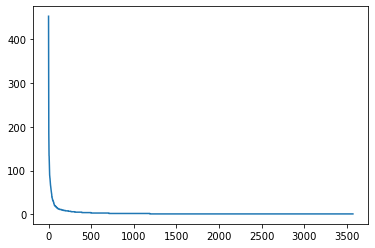

In [6]:
df_cnt['count'].plot()

<AxesSubplot:>

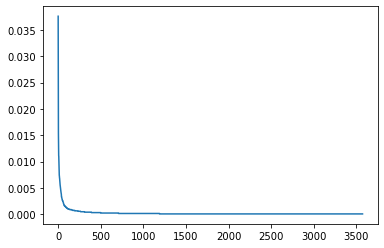

In [7]:
df_cnt['prob'].plot()

<AxesSubplot:>

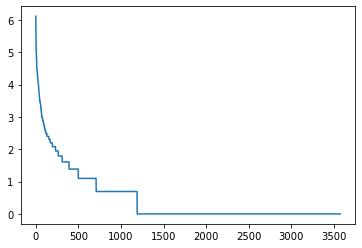

In [8]:
df_cnt['count_log'].plot()

<AxesSubplot:>

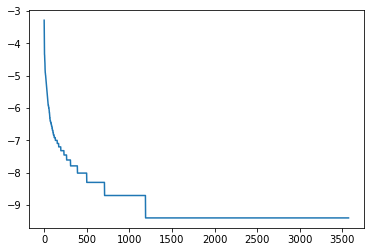

In [9]:
df_cnt['prob_log'].plot()

<AxesSubplot:xlabel='count_log', ylabel='prob_log'>

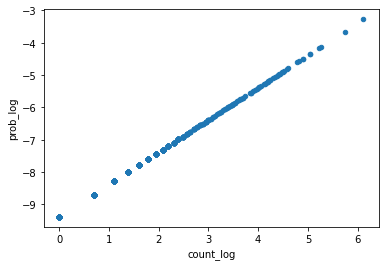

In [10]:
df_cnt.plot.scatter('count_log','prob_log')

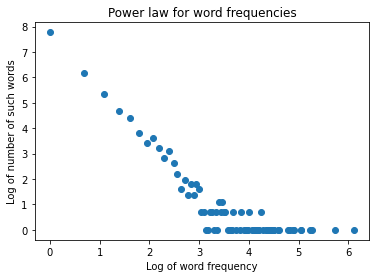

In [11]:
counter_of_words = Counter(txt.split())
counter_of_counts = Counter(counter_of_words.values())
word_counts = np.array(list(counter_of_counts.keys()))
freq_of_word_counts = np.array(list(counter_of_counts.values()))
plt.scatter(np.log(word_counts), np.log(freq_of_word_counts))
plt.xlabel('Log of word frequency')
plt.ylabel('Log of number of such words')
plt.title('Power law for word frequencies')
plt.show();

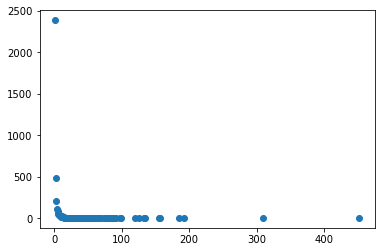

In [12]:
plt.scatter(word_counts, freq_of_word_counts)

## Estimate slope

In [13]:
def neg_zipf_likelihood(s):
    n = sum(freq_of_word_counts)
    # for each word count, find the probability that a random word has such word count
    probas = word_counts ** (-s) / np.sum(np.arange(1, n+1) **(-s))
    log_likelihood = sum(np.log(probas) * word_counts)
    return -log_likelihood

from scipy.optimize import minimize_scalar
s_best = minimize_scalar(neg_zipf_likelihood, [0.1, 3.0] )
print(s_best.x)

0.8792971547915152


## Exponential vs power law

In [14]:
x=np.arange(1, 1000)[::-1]
const=3
y_p=0.000003*x**const
y_e=1.01**x

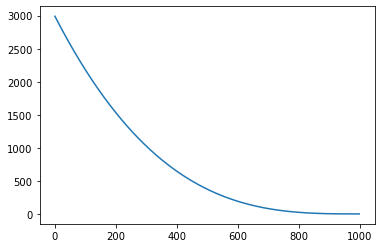

In [15]:
plt.plot(y_p)

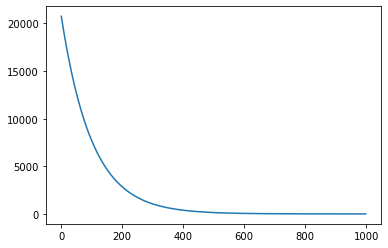

In [16]:
plt.plot(y_e)

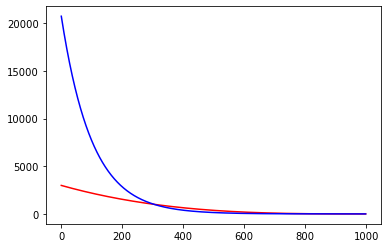

In [17]:
plt.plot(y_p, color='red')
plt.plot(y_e, color='blue')

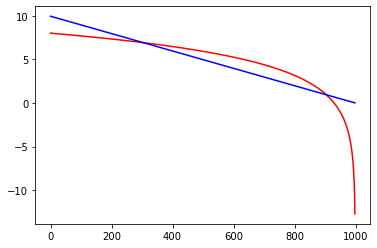

In [18]:
plt.plot(np.log(y_p), color='red')
plt.plot(np.log(y_e), color='blue')

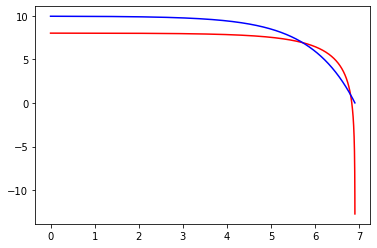

In [19]:
plt.plot(np.log(x)[::-1], np.log(y_p), color='red')
plt.plot(np.log(x)[::-1], np.log(y_e), color='blue')

## Example: https://notebook.community/puolival/power-law/powerlaw

In [20]:
def random(size=1, xmin=1, alpha=1.5):
    """Draw random numbers from a power-law distribution using the inverse
    random sampling method.

    Input arguments:
    size  - Sample size
    xmin  - Minimum value for which the power-law holds
    alpha - Scaling exponent of the power-law distribution
    """
    rvs = np.random.random(size=size)
    return float(xmin) * (1.-rvs) ** (-1. / (float(alpha)-1.))

In [21]:
-1. / (float(2.5)-1.)

-0.6666666666666666

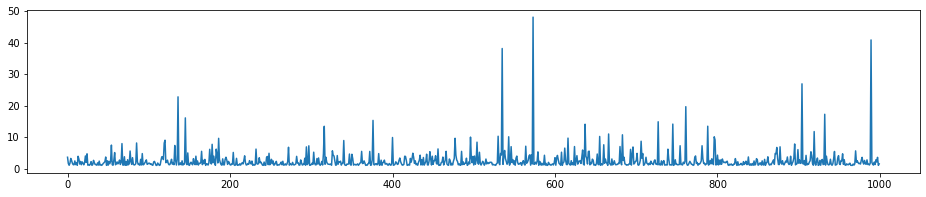

In [22]:
rvs = random(size=1000, xmin=1, alpha=2.5)
plt.figure(figsize=(16, 3)); 
plt.plot(rvs); 
plt.show()

In [23]:
def plot_ccdf(rvs):
    """Plot complementary cumulative distribution function (CCDF) of
    a possibly power-law distributed sample.

    Input arguments:
    rvs   - Analyzed random sample
    """
    # Calculate complementary CDF
    n = np.size(rvs)
    xcdf, ycdf = np.sort(rvs), np.arange(n, 0, -1) / float(n)

    # Visualize the CDF
    fig = plt.figure(figsize=(8, 6))
    ax1 = fig.add_subplot(111)
    ax1.loglog(xcdf, ycdf, 'o', fillstyle='none')

def mle_alpha(rvs, xmin):
    """Maximum likelihood (ML) estimate of the scaling parameter
    alpha."""
    # Select observation larger than or equal to xmin
    rvs = rvs[rvs>=xmin]
    n = np.size(rvs)

    return 1. + n * (1. / np.sum(np.log(rvs / float(xmin))))

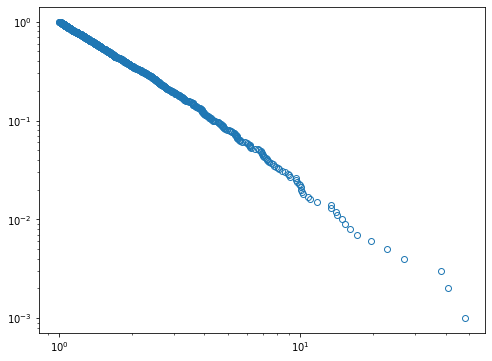

In [24]:
plot_ccdf(rvs)

C:\Users\RistoHinno\AppData\Local\Temp\ipykernel_44584\3915412209.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(np.sort(rvs)), np.log((np.array(list(range(len(rvs))))/len(rvs))[::-1]), 'bo')


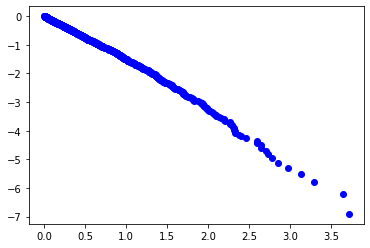

In [25]:
plt.plot(np.log(np.sort(rvs)), np.log((np.array(list(range(len(rvs))))/len(rvs))[::-1]), 'bo')

In [26]:
#scaling parameter
mle_alpha(rvs, xmin=1)

2.54108567241345

## How mean changes when number of samples change

In [250]:
power_dist = powerlaw.Power_Law(xmin=5.0, parameters=[2.5])
exp_dist = powerlaw.Exponential(xmin=5.0, parameters=[0.4])
# theoretical_distribution = powerlaw.Power_Law(xmin=5.0, parameters=[2.5])

In [251]:
exp_data = exp_dist.generate_random(1000000)
power_data

array([ 7.88138243, 12.73070656,  7.23379809, ..., 15.13184726,
       18.58339964,  5.41037357])

In [252]:
exp_data

array([ 5.49682048,  5.89359356,  9.37514471, ..., 12.99180078,
        7.05660584,  7.67400745])

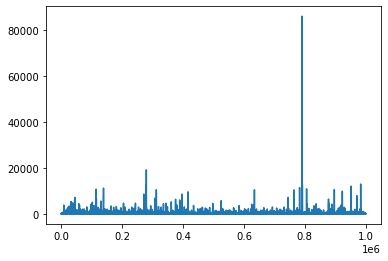

In [253]:
plt.plot(power_data)

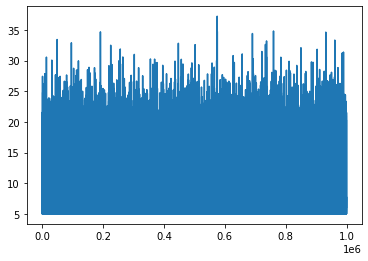

In [254]:
plt.plot(exp_data)

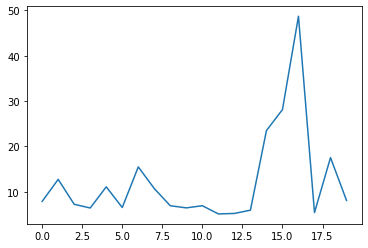

In [255]:
#plot only first samples
plt.plot(power_data[:20])

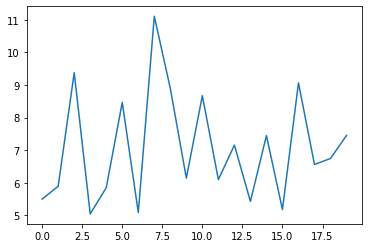

In [256]:
plt.plot(exp_data[:20])

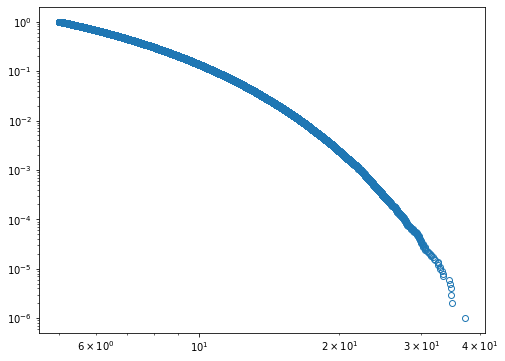

In [257]:
plot_ccdf(exp_data)

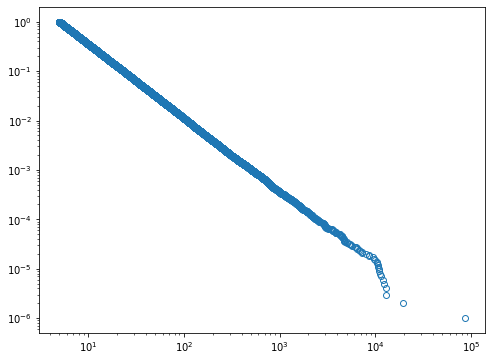

In [258]:
plot_ccdf(power_data)

In [263]:
sample_sizes=[10**i for i in range(1, 7)]
data=[]
for size in sample_sizes:
    power_samp=np.random.choice(power_data, size=size, replace=False)
    exp_samp=np.random.choice(exp_data, size=size, replace=False)
    data.append({'sample_size':size,
                 'power_max': np.max(power_samp),
                'power_mean':np.mean(power_samp),
                'power_median': np.median(power_samp),
                'exp_max':np.max(exp_samp),
                'exp_mean':np.mean(exp_samp),
                'exp_median':np.median(exp_samp)})
    
df_power_exp=pd.DataFrame(data)
df_power_exp=df_power_exp.set_index(df_power_exp['sample_size'])
df_power_exp.shape

(6, 7)

In [264]:
df_power_exp

,sample_size,power_max,power_mean,power_median,exp_max,exp_mean,exp_median
sample_size,,,,,,,
10,10,28.021967,11.998551,7.709706,12.130759,6.615043,5.716284
100,100,225.866722,12.139229,7.726001,15.576599,7.606506,6.854556
1000,1000,770.995980,14.937054,7.957090,25.135349,7.497370,6.710011
10000,10000,8636.894393,15.348177,7.891113,26.230960,7.462390,6.740584
100000,100000,10757.383968,14.546003,7.944293,33.437483,7.492267,6.730095
1000000,1000000,86045.493941,14.938120,7.944879,37.231033,7.500406,6.732672


<AxesSubplot:xlabel='sample_size'>

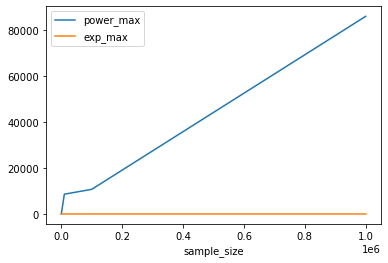

In [265]:
#maximum value we have seen is hugeliy bigger under powerlaw distribution
df_power_exp[['power_max', 'exp_max']].plot()

<AxesSubplot:xlabel='sample_size'>

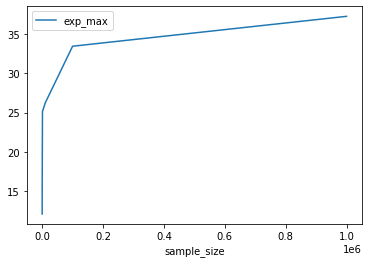

In [266]:
#in a different scale exponential function maximums have also big growth, but they are a lot smaller
df_power_exp[['exp_max']].plot()